# HW6

In [1]:
import numpy as np # numerical library
import matplotlib.pyplot as plt # plotting library
%config InlineBackend.figure_format='retina' # high-res plots
import control.matlab as ctm # matlab layer for control systems library
import control as ct # use regular control library for a few things
ct.set_defaults('statesp', latex_repr_type='separate') # ABCD matrices
import scipy.signal
import control
import math

## plant model
The A and B matrices for a state equation of the dynamics
of the DC Motors System in the University of Washington's
Control Systems Laboratory are below. 

The state vector is taken to be
 `[i1  i2  theta1  omega1  theta2  omega2].T`

the input is vector taken to be

`[e1  e2].T`

where

`i1` = Current of drive motor (A)

`i2` = Current of the load motor (A)

`theta1` = Angular position of shaft 1 (rad)

`omega1` = Angular velocity of shaft 1 (rad/sec)

`theta2` = Angular position of shaft 2 (rad)

`omega2` = Angular velocity of shaft 2 (rad/sec)

`e1` = Drive motor amplifier input voltage

`e2` = Load motor amplifier input voltage

In [2]:
# Drive motor and drive motor amplifier parameters
K1 = 99e-3     # Motor constant (V/(rad/sec))
R1 = 2.13      # Armature resistance (ohms)
Dm1 = 1.27e-4  # Motor damping constant (N*m/(rad/sec))
L1 = 0.686e-3  # Armature inductance (H)
Jm1 = 26.9e-6  # Motor inertia (kg*m**2)
Ka1 = 32.2     # Gain of amplifier gain for drive motor (V/V)
Ra1 = 0.2      # Resistance of amplifier for drive motor (ohms)

# Load motor and load motor amplifier parameters
K2 = 62e-3     # Motor constant (V/(rad/sec))
R2 = 1.2       # Armature resistance (ohms)
Dm2 = 60e-6    # Motor damping constant (N*m/(rad/sec))
L2 = 2.1e-3    # Armature inductance (H)
Jm2 = 24.38e-6 # Motor inertia (kg*m**2)
Ka2 = 32.2     # Amplifier gain for drive motor (V/V)
Ra2 = 0.2      # Amplifier resistance for drive motor (ohms)

# Other parameters
J1 = 1.25e-3   # Inertial load on theta1 shaft (kg*m**2)
J2 = 1.0e-3    # Inertial load on theta2 shaft (kg*m**2)
D1 = 42.35e-6  # Viscous friction coefficient for theta1 shaft(N*m/(rad/sec))
D2 = 42.35e-6  # Viscous friction coefficient for theta2 shaft (N*m/(rad/sec))
n = 5.0        # Gear ratio
Ks = 100       # Shaft stiffness (N*m/rad)

# Generate State Model Matrices
Jeq1 = J1 + n**2*Jm1
Jeq2 = J2 + Jm2
Deq1 = D1 + n**2*Dm1
Deq2 = D2 + Dm2

a11 = -(Ra1+R1)/L1
a14 = -n*K1/L1
a22 = -(Ra2 + R2)/L2
a26 = -K2/L2
a41 = n*K1/Jeq1
a43 = -Ks/Jeq1
a44 = -Deq1/Jeq1
a45 = Ks/Jeq1
a62 = K2/Jeq2
a63 = Ks/Jeq2
a65 = -Ks/Jeq2
a66 = -Deq2/Jeq2
b11 = Ka1/L1
b22 = Ka2/L2

A = np.array(
    [[a11,     0,        0,      a14,       0,        0],
     [0,     a22,        0,        0,       0,      a26],
     [0,       0,        0,        1,       0,        0],
     [a41,     0,      a43,      a44,     a45,        0],
     [0,       0,        0,        0,       0,        1],
     [0,     a62,      a63,        0,     a65,      a66]])
B = np.array(
    [[b11,   0],
     [0,   b22],
     [0,     0],
     [0,     0],
     [0,     0],
     [0,     0]])
C = np.array(
    [[0 ,0, 1, 0, 0, 0 ],
     [0 ,0, 0, 0, 1, 0]])
D = np.array(
    [[0,   0],
     [0,   0]])



# State-space plant model

In [3]:
plant = ctm.ss(A, B, C, D ,inputs=['e1', 'e2'], outputs=['theta1', 'theta2'])

display(plant)

<LinearIOSystem:sys[2]:['e1', 'e2']->['theta1', 'theta2']>

In [4]:
Ts = 0.02
plantdisc = ctm.ss(ctm.c2d(plant, Ts, 'zoh'), inputs=['e1', 'e2'], outputs=['theta1', 'theta2']) # discrete-time model of plant

# Connect to dis

In [5]:
c_of_z = ctm.tf2ss([0.55, 0.55*(-1.45515), 0.55*0.45997265], [1, -1.2, 0.2], Ts, inputs = 'theta2_ref', outputs = 'e1')

loop_theta1 = ct.interconnect((plantdisc, c_of_z), inputs = 'theta2_ref', outputs = 'theta1')
loop_theta2 = ct.interconnect((plantdisc, c_of_z), inputs = 'theta2_ref', outputs = 'theta2')

C:\Users\ROG\anaconda3\lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (0, 1)=sys[2]$sampled.e2
  warn(msg)
C:\Users\ROG\anaconda3\lib\site-packages\control\iosys.py:1509: UserWarning: Unused output(s) in InterconnectedSystem: (0, 1) : sys[2]$sampled.theta2
  warn(msg)
C:\Users\ROG\anaconda3\lib\site-packages\control\iosys.py:1509: UserWarning: Unused output(s) in InterconnectedSystem: (0, 0) : sys[2]$sampled.theta1
  warn(msg)


# Problem A

### Theta1 pahse margin

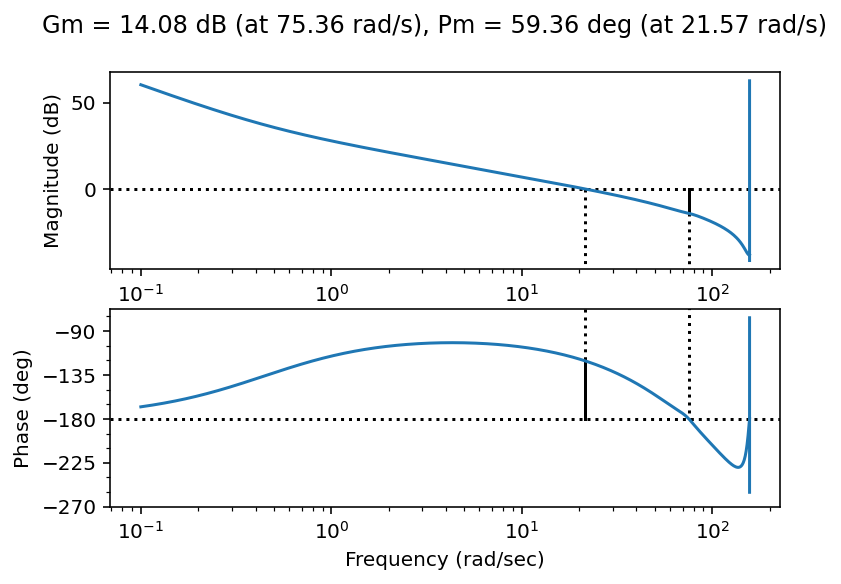

In [6]:
ctm.bode(loop_theta1, margins = True);

### Theta2 pahse margin

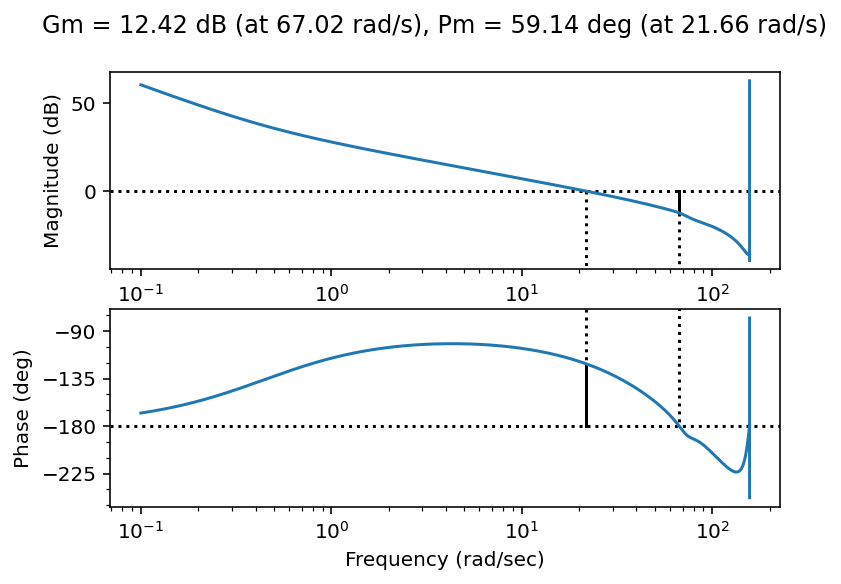

In [7]:
ctm.bode(loop_theta2, margins = True);

# Part B,C

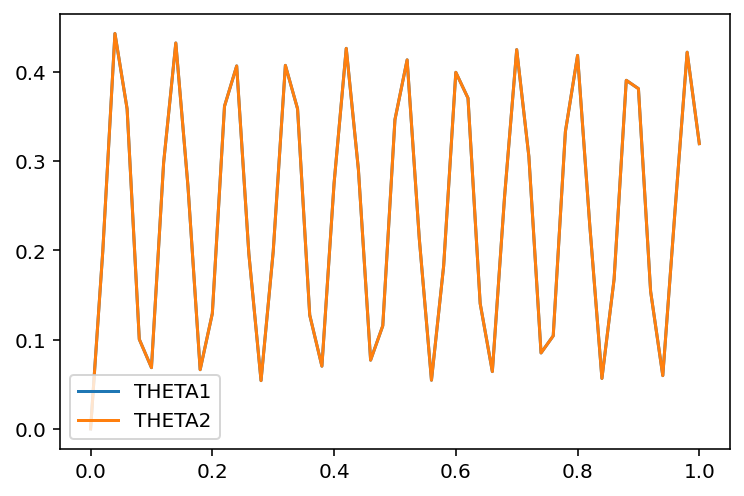

In [8]:
gain = 10**(12.42/20)

K = ctm.tf2ss(gain, 1, Ts, inputs='theta2', outputs='K_out')

error = ct.summing_junction(['theta2_ref', '-K_out'], 'e')

c_of_z = ctm.tf2ss([55, 55*(-0.991-0.46415), 55*(0.991*0.46415)], [100, 100*(-1-0.2), 100*0.2], Ts, 
            inputs='e', outputs='e1')

sys_dis_sensor = ct.interconnect([plantdisc, c_of_z, error, K], 
                          inputs=['theta2_ref', 'e2'], outputs=['theta1', 'theta2'])

theta1_sys = sys_dis_sensor[0, 0]
y1, t1 = ctm.step(theta1_sys, 1)
plt.plot(t1, y1, label='THETA1')

theta2_sys = sys_dis_sensor[0, 0]
y2, t2 = ctm.step(theta2_sys, 1)
plt.plot(t2, y2, label='THETA2')

plt.legend(loc='best')

# Part D, E

## USE MATLAB TO SOLVE